In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import datetime 
import sys
import datetime as dt
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV,train_test_split, GridSearchCV
from sklearn.decomposition import PCA

In [25]:
# Input: Takes in dataframe of 'coin_Bitcoin.csv' or other related coin datasets
# Output: A dataframe with added labels for increasing/not increasing
def create_labels(df):
    df['NextClose'] = df['Close'].shift(-1)
    df.loc[df['NextClose'] > df['Close'], 'Change'] = 'Increase'
    df.loc[df['NextClose'] <= df['Close'], 'Change'] = 'No Increase'
    df = df.dropna()
    df = df.drop('NextClose', axis=1)
    
    vals = df.groupby('Change').count()
    ratio = vals.loc['Increase']['SNo'] / (vals.loc['Increase']['SNo'] + vals.loc['No Increase']['SNo'])
    
    # Show the ratio of Increase to No Increase rows. This will indicate if the dataset is inbalanced 
    # if it far from a 50/50 split
    print(ratio, 1-ratio)
    
    return df

# Input: Takes in dataframe with column 'date
# Output: Turns the date column into datetime object 
def process_date(df):
    df['date' ]= pd.to_datetime(df['date'], errors='coerce').dt.date
    return df

# Input: Dataframe from the currency (eg. coin_Bitcoin.csv) datasets
# Output: removes unused columns and sets index to date
def process_currency(df):
    bit_info = df.drop(['SNo', 'Name', 'Symbol'], axis=1)
    bit_info = bit_info.rename(columns={'Date': 'date'})
    bit_info['date'] = pd.to_datetime(bit_info['date']).dt.date
    return bit_info
    

# Input: Two dataframes with 'date' column
# Output: The result of merging the two dataframes
def merge_on_date(df1, df2):
    merging = df1.merge(df2, on='date')
    return merging

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# Input: A dataframe post merging, an output DIRECTORY
# Output: runs random forest regression to predict closing price

# HyperParameter tuning found at:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
def random_forest_regression(df, out_dir):
    
    X = df.drop(['High', 'Low', 'Close', 'Open', 'Change'], axis=1)
    X = X.drop(['Marketcap'], axis=1)
    # X = X.drop(['Volume'], axis=1)
    y = df.Close
    dates = df.date
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
    
    train_dates = X_train.date
    valid_dates = X_valid.date
    
    X_train = X_train.drop('date', axis=1)
    X_valid = X_valid.drop('date', axis=1)
    
    # Test train split into the first 80% as our train, and last 20% for test
    #X_train = X.iloc[0:int(0.8*X.shape[0])]
    #X_valid = X.iloc[int(0.8*X.shape[0]):]
    #y_train = y.iloc[0:int(0.8*y.shape[0])]
    #y_valid = y.iloc[int(0.8*y.shape[0]):]
    
    
    # HyperParameter tuning
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 100)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(2, 30, num = 2)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 3, 4, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4, 8]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

#     estimators = 300
#     depth = 7
#     split = 50
#     model = make_pipeline(
#             StandardScaler(),
#             RandomForestRegressor(n_estimators=estimators,
#             max_depth=depth , min_samples_split=split, min_samples_leaf=15)
#         )
#     model.fit(X_train, y_train)

#     pipe = make_pipeline(
#                 StandardScaler(),
#                 RandomForestRegressor()
#             )
    rf = RandomForestRegressor()
    model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                                   n_iter = 30, cv = 3, verbose=3, random_state=42, n_jobs = -1)
    
    model.fit(X_train, y_train)
    
    
    base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
    base_model.fit(X_train, y_train)
    base_accuracy = evaluate(base_model, X_valid, y_valid)
    
    best_random = model.best_estimator_
    random_accuracy = evaluate(best_random, X_valid, y_valid)
    
    print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


    print('valid data score=%.5g' % (model.score(X_valid, y_valid)))
    print('training data score=%.5g' % (model.score(X_train, y_train)))

    plt.figure(figsize=(8, 5))
    plt.scatter(dates, y)
    plt.plot(valid_dates, model.predict(X_valid), 'r.')
    plt.savefig('{}/model_rfr.png'.format(out_dir))
    
    return model.best_params_, base_accuracy

def random_forest_regression_bp(df, best_params, base_accuracy, out_dir):
    
    X = df.drop(['High', 'Low', 'Close', 'Open', 'Change'], axis=1)
    X = X.drop(['Marketcap'], axis=1)
    # X = X.drop(['Volume'], axis=1)
    y = df.Close
    dates = df.date
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
    
    train_dates = X_train.date
    valid_dates = X_valid.date
    
    X_train = X_train.drop('date', axis=1)
    X_valid = X_valid.drop('date', axis=1)
    
    # Test train split into the first 80% as our train, and last 20% for test
    #X_train = X.iloc[0:int(0.8*X.shape[0])]
    #X_valid = X.iloc[int(0.8*X.shape[0]):]
    #y_train = y.iloc[0:int(0.8*y.shape[0])]
    #y_valid = y.iloc[int(0.8*y.shape[0]):]
    
    
    # HyperParameter tuning
    # Create the parameter grid based on the results of best search 
    bootstrap = best_params['bootstrap']
    max_depth = best_params['max_depth']
    max_features = best_params['max_features']
    min_samples_leaf = best_params['min_samples_leaf']
    min_samples_split = best_params['min_samples_split']
    n_estimators = best_params['n_estimators']
    if max_depth is not None:
        param_grid = {
            'bootstrap': [bootstrap],
            'max_depth': [max_depth+1, max_depth+2, max_depth+3],
            'max_features': [max_features],
            'min_samples_leaf': [min_samples_leaf, min_samples_leaf+1, min_samples_leaf+2, min_samples_leaf+3],
            'min_samples_split': [min_samples_split, min_samples_split+2, min_samples_split+4, min_samples_split+6, min_samples_split+8, min_samples_split+10],
            'n_estimators': [n_estimators, n_estimators+100, n_estimators+200, n_estimators*10]
        }
    else:
        param_grid = {
            'bootstrap': [bootstrap],
            'max_depth': [max_depth],
            'max_features': [max_features],
            'min_samples_leaf': [min_samples_leaf, min_samples_leaf+1, min_samples_leaf+2, min_samples_leaf+3],
            'min_samples_split': [min_samples_split, min_samples_split+2, min_samples_split+4, min_samples_split+6, min_samples_split+8, min_samples_split+10],
            'n_estimators': [n_estimators, n_estimators+100, n_estimators+200, n_estimators*10]
        }
    
    # Create a based model
    rf = RandomForestRegressor()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = 3, n_jobs = -1, verbose = 2)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    grid_search.best_params_
    
    best_grid = grid_search.best_estimator_
    grid_accuracy = evaluate(best_grid, X_valid, y_valid)
    
    print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))
    
    print('valid data score=%.5g' % (grid_search.score(X_valid, y_valid)))
    print('training data score=%.5g' % (grid_search.score(X_train, y_train)))

    plt.figure(figsize=(8, 5))
    plt.scatter(dates, y)
    plt.plot(valid_dates, grid_search.predict(X_valid), 'r.')
    plt.savefig('{}/model_rfrb.png'.format(out_dir))
    

# TODO: look up which week exercise we used polyfit
# Note: this code is adapted from the exercise ___
def score_polyfit(n, X_train, y_train, X_valid, y_valid):
    
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree=n, include_bias=True),
        LinearRegression(fit_intercept=False)
    )
    
    model.fit(X_train, y_train)

    print('n={}: valid data score=%.5g'.format(n) % (model.score(X_valid, y_valid)))
    print('n={}: training data score=%.5g'.format(n) % (model.score(X_train, y_train)))
    
    return model

# Input: n <- degree of the polynomial
#       df <- dataframe to train
#  out_dir <- directory to store image
def linear_regression(n, df, out_dir):
    
    X = df.drop(['High', 'Low', 'Close', 'Open', 'Change'], axis=1)
    X = X.drop(['Marketcap'], axis=1)
    # X = X.drop(['Volume'], axis=1)
    y = df.Close
    dates = df.date
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
    
    train_dates = X_train.date
    valid_dates = X_valid.date
    
    X_train = X_train.drop('date', axis=1)
    X_valid = X_valid.drop('date', axis=1)
    
    model = score_polyfit(n, X_train, y_train, X_valid, y_valid)
    
    plt.figure(figsize=(8, 5))
    plt.scatter(dates, y)
    plt.plot(valid_dates, model.predict(X_valid), 'r.')
    plt.savefig('{}/model_lr.png'.format(out_dir))
    

def boosted_regression(df, out_dir):
    
    X = df.drop(['High', 'Low', 'Close', 'Open', 'Change'], axis=1)
    X = X.drop(['Marketcap'], axis=1)
    # X = X.drop(['Volumn'], axis=1)

    y = df.Close
    dates = df.date
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
    
    train_dates = X_train.date
    valid_dates = X_valid.date
    
    X_train = X_train.drop('date', axis=1)
    X_valid = X_valid.drop('date', axis=1)
    
    estimators = 300
    depth = 10
    split = 25
    
    model = GradientBoostingRegressor(n_estimators=estimators,
            max_depth=depth , min_samples_split=split, min_samples_leaf=5)
    model.fit(X_train, y_train)
    print('valid data score=%.5g' % (model.score(X_valid, y_valid)))
    print('training data score=%.5g' % (model.score(X_train, y_train)))
    
    plt.figure(figsize=(8, 5))
    plt.scatter(dates, y)
    plt.plot(valid_dates, model.predict(X_valid), 'r.')
    plt.savefig('{}/model_br.png'.format(out_dir))
    
def main():
    
    # To run:
    # create output directory for .png images
    
    # python3 Model.py coin_Bitcoin.csv DailyAverages.csv output
    # OR
    # python3 Model.py coin_Bitcoin.csv DailySum.csv output
    
    # for now we are just merging two datasets
    # in_dir1 = sys.argv[1] # coin_Bitcoin.csv (or other currency datasets)
    # in_dir2 = sys.argv[2] # one of (DailyAverages.csv, DailySum.csv)
    # out_dir = sys.argv[3] # folder to save images
    
    in_dir1 = 'coin_Bitcoin.csv'
    in_dir2 = 'DailyAverages.csv'
    out_dir = 'Images'
    
    
    df_bitcoin = pd.read_csv(in_dir1, parse_dates=['Date'])
    df_reddit = pd.read_csv(in_dir2, parse_dates=['date'])
    
    # Pre processing for coin_Bitcoin.csv (or other currency datasets)
    df_bitcoin = create_labels(df_bitcoin)
    df_bitcoin = process_currency(df_bitcoin)
    df_bitcoin = process_date(df_bitcoin)
    
    # Pre processing for one of (DailyAverages.csv, DailySum.csv)
    df_reddit = process_date(df_reddit)
    
    # Merges the two datasets on 'date'
    merged = merge_on_date(df_bitcoin, df_reddit)
    
    # merged = merged[merged['date'] > dt.date(2017, 1, 1)]
    
    n = 3
    best_params, base_accuracy = random_forest_regression(merged, out_dir)

    random_forest_regression_bp(merged, best_params, base_accuracy, out_dir)
    linear_regression(n, merged, out_dir)
    boosted_regression(merged, out_dir)
    

0.540133779264214 0.459866220735786
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Model Performance
Average Error: 550.2027 degrees.
Accuracy = 73.81%.
Model Performance
Average Error: 555.2336 degrees.
Accuracy = 73.35%.
Improvement of -0.62%.
valid data score=0.92112
training data score=0.98413
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Model Performance
Average Error: 533.6801 degrees.
Accuracy = 74.32%.
Improvement of 0.70%.
valid data score=0.92172
training data score=0.9753
n=3: valid data score=0.86879
n=3: training data score=0.91353
valid data score=0.91937
training data score=0.99953


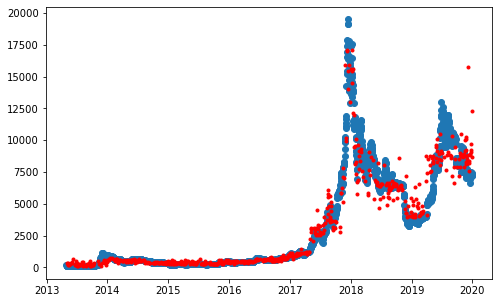

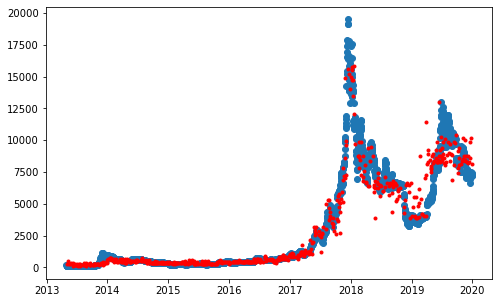

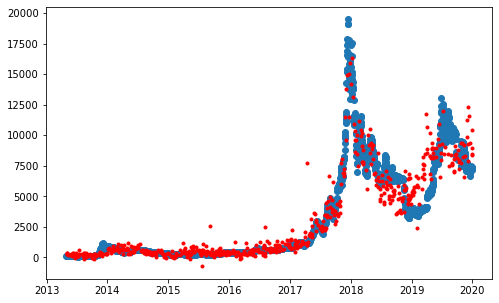

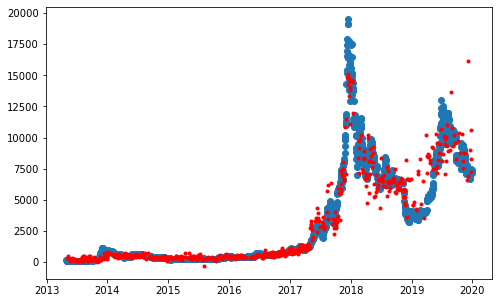

In [26]:
if __name__== '__main__':
    main()